# General data reader for AQUA 
## Example of datasets on Lumi

We added a few new data sources to the intake catalogue, pointing to resources already available on LUMI.

### Inspecting available datasets

Multiple datasets area available also for observations, so that we can also inspect the catalogue by checking what is inside. This can be done with the `inspect_catalogue` function

In [1]:
from aqua import catalogue, inspect_catalogue
from aqua import Reader
cat = catalogue()

IFS	fdb-tco399	fdb-long data tco399 grid
	- fdb-long-2d	FDB data tco399 grid
	- fdb-long-3d	FDB data tco399 grid

IFS-NEMO	control-1950-dev	FDB IFS/NEMO tco1279-orca025 control 1950 run
	- hourly-native	hourly data on native grid TCo1279 (about 10km). Contains tprate(260048), 2t(167), 10u(165), 10v(166), 100u(228246), 100v(228247), sr(173), blh(159), 2d(168), skt(235), chnk(148). See fix yaml for derived vars.
	- hourly-1deg	hourly data on r100 grid. Contains tprate(260048), sf(144), 2t(167), 10u(165), blh(159), sshf(146), slhf(147), ssrd(169), ssr(176), strd(175), str(177), ttr(179), e(182), tsr(178), ewss(180), nsss(181), chnk(148), sro(8), ssro(9). See fix yaml for derived vars.
	- 6hourly-1deg	6hourly data on r100 grid. Contains z(129).
	- monthly-1deg-2d	monthly data on r100 grid. Contains tcc(164), sd(141), tciw(79), tclw(78), msl(151), tcwv(137), lcc(186), mcc(187), hcc(188).
	- monthly-1deg-3d	monthly data on r100 grid. Contains u(131), v(132), t(130), r(157), q(133).
	- lra-r1

Here below a short exploration at cataogue, model and experiment level

In [2]:
inspect_catalogue(cat)

Models available in catalogue:


['IFS',
 'IFS-NEMO',
 'FESOM',
 'NEMO',
 'ICON',
 'ERA5',
 'MSWEP',
 'CERES',
 'PHC3',
 'WOA18',
 'OSI-SAF',
 'EN4',
 'AVISO',
 'PSC']

In [3]:
inspect_catalogue(cat, model = 'IFS-NEMO')

Experiments available in catalogue for model IFS-NEMO:


['control-1950-dev', 'historical-1990-dev']

In [4]:
inspect_catalogue(cat, model = 'IFS-NEMO', exp = 'control-1950-dev')

Sources available in catalogue for model IFS-NEMO and exp control-1950-dev:


['hourly-native',
 'hourly-1deg',
 '6hourly-1deg',
 'monthly-1deg-2d',
 'monthly-1deg-3d',
 'lra-r100-monthly']

## FDB/GSV access

We implemented FDB access in the reader using the GSV reader interface and a new intake driver which we developed. Also in this case the idea is to 'shield' the users from complex mars-style requests, allowing them to focus on the desired variables and experiments.

IFS model is available in this format for the develpoment integrations, as well as two 'mock dataset' which uses ERA5 variables: the "fdb-test" dataset and a "fdb-long" datasets, including some common climate variables, for a few days (the former) and few years (the latter). as described in the [GSV Reader fdb-test documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specification-of-fdb-test) and [GSV Reader fdb-long documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).

The default is now returning a standard dask-enabled xarray thanks to recent improvements to the interface which allow lazy dask access also for FDB/GSV data sources. It is still possible to obtain an iterator instead, specifying the `stream_generator=True` keyword.

Xarray/dask access (the default) is the recommended data access form, since it is the same used also for other data sources.

### Access to the fdb-test archive using dask

In [5]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test", loglevel='info')
data = reader.retrieve(var='tcc')

/pfs/lustrep4/users/padavini/AQUA/aqua/reader/reader.py:149: DeprecationWarning: Default experiment based fixes are used. This will be deprecated in the future.
  self.fixes = self.find_fixes()  # find fixes for this model/exp/source
2023-12-18 13:56:43 :: Reader :: INFO     -> For source fdb-test, method for fixes is: replace
2023-12-18 13:56:43 :: Reader :: INFO     -> Grid metadata is lon-lat
2023-12-18 13:56:49 :: Reader :: INFO     -> vert_coord deduced from the source are 2d
/LUMI_TYKKY_9G5WcbQ/miniconda/envs/env1/lib/python3.11/site-packages/metpy/io/nexrad.py:14: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from xdrlib import Unpacker
2023-12-18 13:56:53 :: Reader :: INFO     -> Retrieving variables: ['tcc']
2023-12-18 13:56:53 :: Reader :: WARNING  -> No variables in the fixes for source fdb-test
2023-12-18 13:56:53 :: Reader :: WARNING  -> Returning the original variable
2023-12-18 13:56:54 :: Reader :: INFO     -> coordinates adjusted to

This produces a regular dask xarray Dataset:

In [6]:
data

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 43393)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 720, 1440), meta=np.ndarray>
Attributes:
    history:  2023-12-18 13:56:54 Dataset retrieved by GSV interface;\n2023-1...

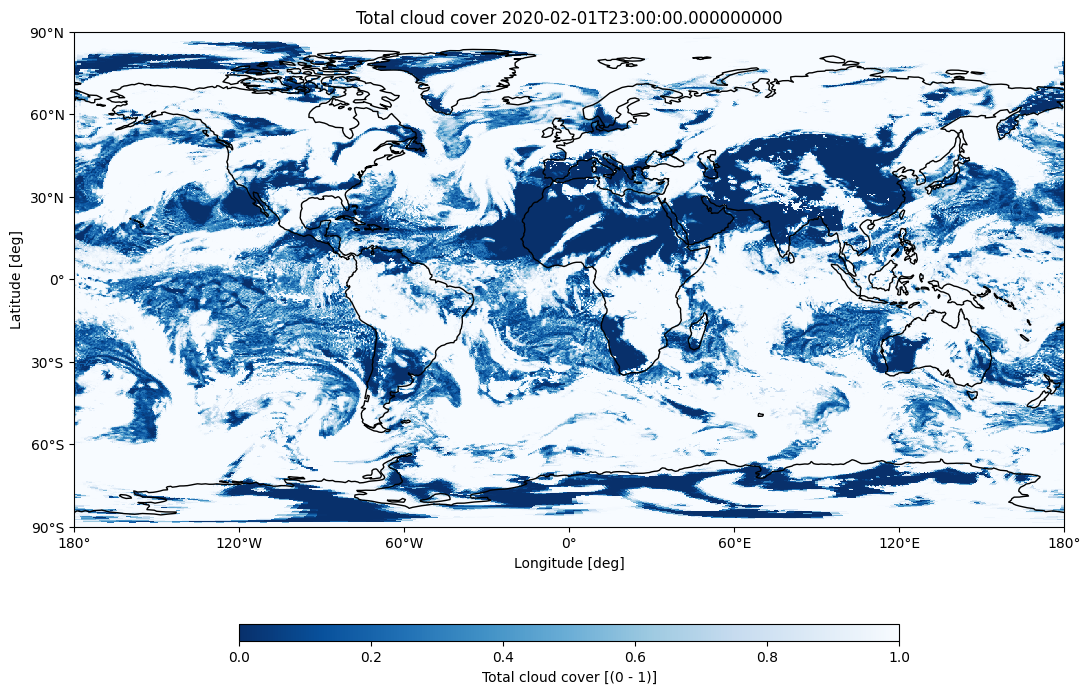

In [7]:
from aqua import plot_single_map

plot_single_map(data.sel(time="20200201T2300").tcc, cmap='Blues_r', contour=False)

### Access to the fdb-test dataset using an iterator

It is also possible to get an iterator instead of a dask array using the keyword `stream_generator=True`. For FDB sources this actually uses an iterator created directly by the GSV intake driver, instead of the streaming simulator. Notice the use, in this example, of the `aggregation` keyword, to specify aggregation/chunking, i.e. how much data to retrieve at each iteration. This keyword, if specified, has actually also a meaning for dask access, specifying chunk size, but is better to just use the defaults read from the catalogue and not to specify it. The defaults take into account memory limitations in chunking. Please check the documentation for further information on how to add a source from FDB.

In [8]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test", regrid="r200", aggregation="D", stream_generator=True)

/pfs/lustrep4/users/padavini/AQUA/aqua/reader/reader.py:149: DeprecationWarning: Default experiment based fixes are used. This will be deprecated in the future.
  self.fixes = self.find_fixes()  # find fixes for this model/exp/source


In [9]:
data = reader.retrieve(startdate="20200125", enddate="20200129", var="tcc")

2023-12-18 13:57:04 :: Reader :: WARNING  -> No variables in the fixes for source fdb-test
2023-12-18 13:57:04 :: Reader :: WARNING  -> Returning the original variable


The result is now an 'iterator'

In [10]:
data

<generator object FixerMixin._fixergen at 0x7fd47fd9ef40>

We can either loop over the iterator or just get the next value. It is only now that the reader will actually retrieve the field(s) from FDB:

In [11]:
data0 = next(data)

In [12]:
data0

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:00:00
Data variables:
    tcc      (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 0.9973 0.9973 0.9973
Attributes:
    history:  2023-12-18 13:57:08 Dataset retrieved by GSV interface;\n2023-1...

This is the first day. Let's instead loop over the next ones:

In [13]:
for d in data:
    dm = reader.fldmean(d).mean(dim="time").tcc
    print(dm.values)

0.6779889981482511
0.6780318111850079
0.680480838944271
0.6832746275494994


The generator is now exhausted, let's get a fresh one

In [14]:
data = reader.retrieve(startdate="20200401", enddate="20200404", var="tcc")

2023-12-18 13:57:44 :: Reader :: WARNING  -> No variables in the fixes for source fdb-test
2023-12-18 13:57:44 :: Reader :: WARNING  -> Returning the original variable


In [15]:
data

<generator object FixerMixin._fixergen at 0x7fcfe273d840>

The regridder can also operate on iterators:

In [16]:
datar = reader.regrid(data)
datar

<generator object Reader._regridgen at 0x7fcff29f8d60>

In [17]:
next(datar)

<xarray.Dataset>
Dimensions:  (time: 24, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 2020-04-01 ... 2020-04-01T23:00:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 90, 180), meta=np.ndarray>
Attributes:
    history:  2023-12-18 13:58:02 Dataset retrieved by GSV interface;\n2023-1...

### Access to the fdb-long archive

It is possible also to access the [fdb-long archive](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).

In [18]:
from aqua import Reader
reader = Reader(model="IFS", exp="fdb-tco399", source="fdb-long-2d", aggregation="D", regrid="r025", loglevel='info')
data = reader.retrieve(startdate='20200120', enddate='20200413', var='ci')

/pfs/lustrep4/users/padavini/AQUA/aqua/reader/reader.py:149: DeprecationWarning: Default experiment based fixes are used. This will be deprecated in the future.
  self.fixes = self.find_fixes()  # find fixes for this model/exp/source
2023-12-18 13:58:03 :: Reader :: INFO     -> Grid metadata is tco399
2023-12-18 13:58:07 :: Reader :: INFO     -> Space_coords deduced from the source are ['ncells']
2023-12-18 13:58:08 :: Reader :: INFO     -> Retrieving variables: ['ci']
2023-12-18 13:58:09 :: Reader :: INFO     -> No variables to be fixed
2023-12-18 13:58:09 :: Reader :: INFO     -> coordinates adjusted to ifs by AQUA fixer


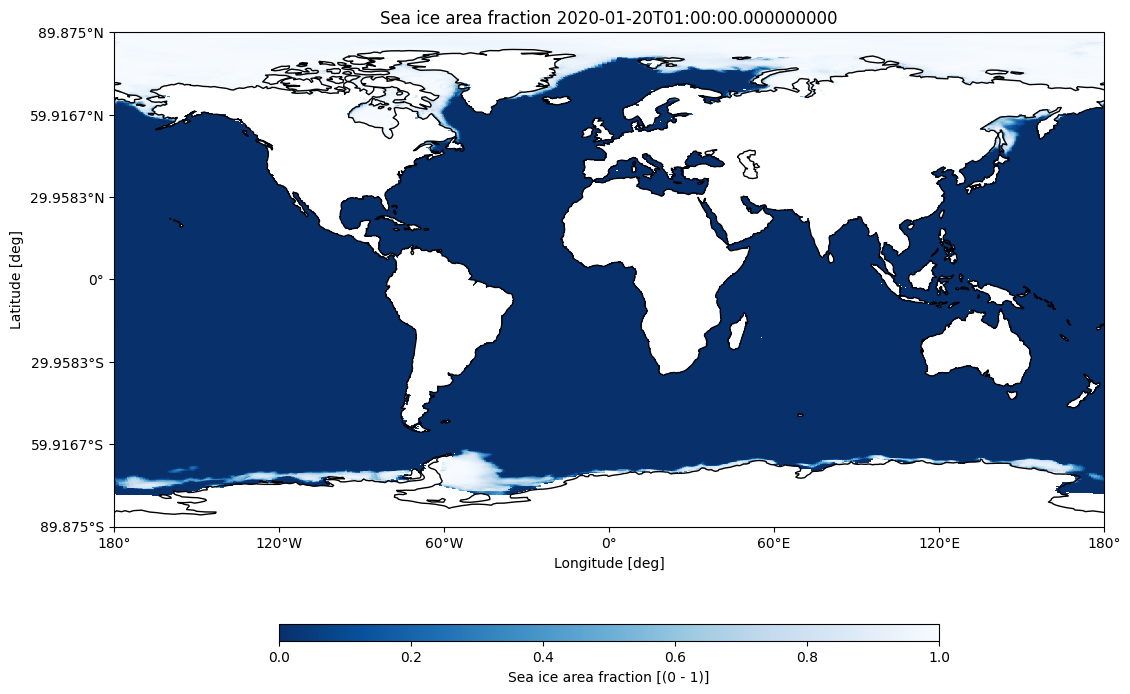

In [19]:
plot_single_map(reader.regrid(data.ci.isel(time=1)), contour=False, cmap='Blues_r')

In [20]:
reader.fldmean(data.ci.isel(time=1)).values

array(0.0413731)

### Access to new IFS-NEMO control and historical runs on LUMI

The new sources have now been added to the catalogue and it is possible to read these data directly from the FDB through the reader

In [21]:
from aqua import Reader
reader = Reader(model='IFS-NEMO', exp='control-1950-dev', source='hourly-1deg')
data = reader.retrieve(var="2t")

2023-12-18 13:59:02 :: Reader :: WARNING  -> Grid file is not defined, retrieving the source itself...
2023-12-18 13:59:09 :: Reader :: WARNING  -> Source areas file not found: /pfs/lustrep3/projappl/project_465000454/data/AQUA/areas/cell_area_IFS-NEMO_control-1950-dev_hourly-1deg.nc
2023-12-18 13:59:09 :: Reader :: WARNING  -> Attempting to generate it ...
2023-12-18 13:59:34 :: Reader :: WARNING  -> Success!


The result is a dataset containing a dask DataArray for the full dataset:

In [22]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 87648)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 ... 1959-12-31T23:00:00
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(24, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-12-18 13:59:41 Dataset retrieved by GSV interface;\n2023-1...

We can now work on this as usual. For example this is the average over the month of January 1952:

In [23]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

array(276.59163528)

This took about 2m48s on LUMI. The data are represented by a dask xarray dataset, so if we use dask parallelism we can speed up things. Let us create a local cluster with 16 cores and two threads per core

In [24]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
cluster

/LUMI_TYKKY_9G5WcbQ/miniconda/envs/env1/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39165 instead
  warnings.warn(


LocalCluster(72643417, 'tcp://193.167.209.166:43531', workers=16, threads=32, memory=64.00 GiB)

Let's try again, this time with a cluster client

In [25]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

2023-12-18 14:02:54,612 - distributed.nanny - WARNING - Restarting worker


array(276.59163528)

Now it took only 29 seconds :)!

Finally, we read correctly also the monthly datasets (behind the scenes the date of these data is aligned so that it corresponds to the actual months): we can also retrieve multiple variables at the time.

In [27]:
from aqua import Reader
reader = Reader(model='IFS-NEMO', exp='control-1950-dev', source='monthly-1deg-2d')
data = reader.retrieve(var=["hcc", "lcc"])

KeyError: 'Experiment control-1950-dev not found in catalog for model IFS.'

In [ ]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 120)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1959-12-01
Data variables:
    hcc      (time, lat, lon) float64 dask.array<chunksize=(12, 181, 360), meta=np.ndarray>
    lcc      (time, lat, lon) float64 dask.array<chunksize=(12, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-12-14 14:26:20 Dataset retrieved by GSV interface;\n\n2023...

Final test: reading the historical simulation natively and converting it on the fly to a 2deg, daily averaged dataset:

In [ ]:
from aqua import Reader
reader = Reader(model='IFS-NEMO', exp='historical-1990-dev', source='hourly-1deg', regrid="r200")
data = reader.retrieve(var="2t")
data = reader.timmean(data, freq='daily')

This is now an xarray of monthly means at low resolution. This took only a few seconds, since nothing has been computed yet (we are using dask)

In [ ]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 365)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-12-14 14:26:34 Dataset retrieved by GSV interface;\n\n2023...

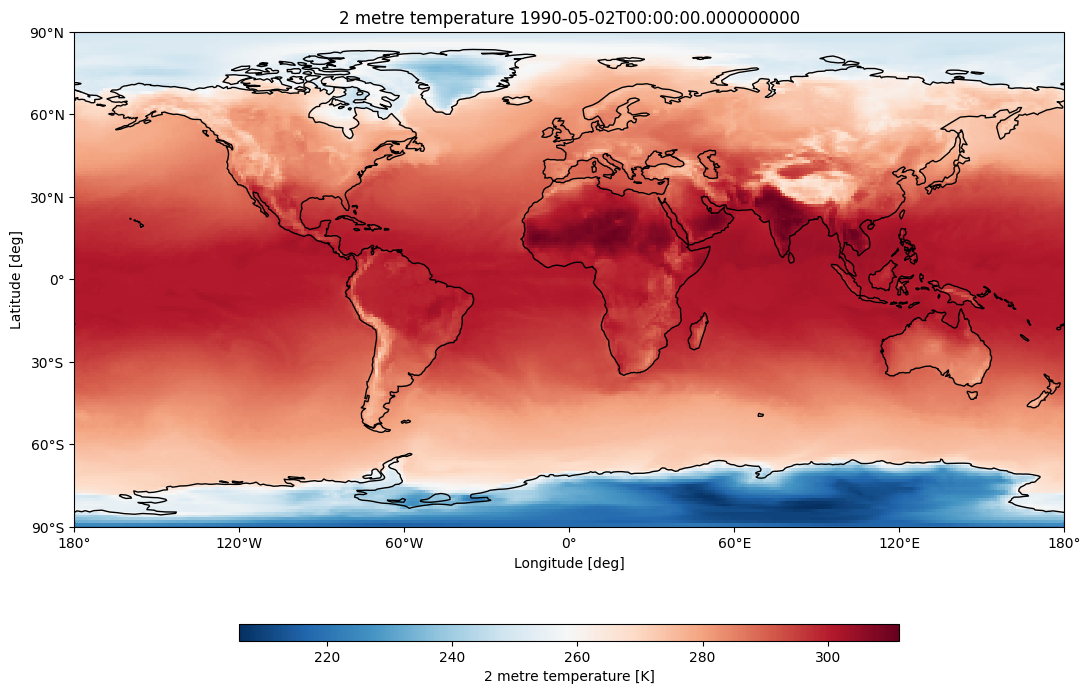

In [ ]:
from aqua import plot_single_map
plot_single_map(data['2t'].sel(time="19900502"), contour=False)
#data['2t'].sel(time="19900502").plot()

Finally let's close the cluster (if you've used it)

In [ ]:
client.close()
